In [22]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [24]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [26]:
train_df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [27]:
categorical_columns = [
    "Marital status",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International",
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)"
]

numerical_columns = [
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

# Look at distributions for numerical columns

Previous qualification (grade)


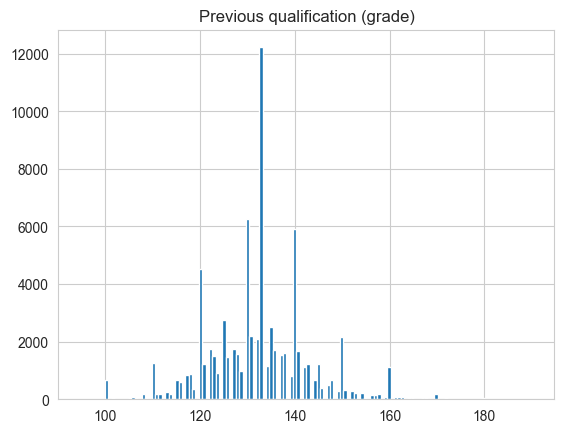

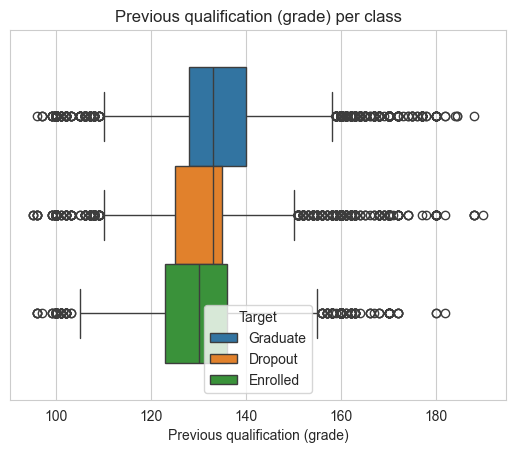

Admission grade


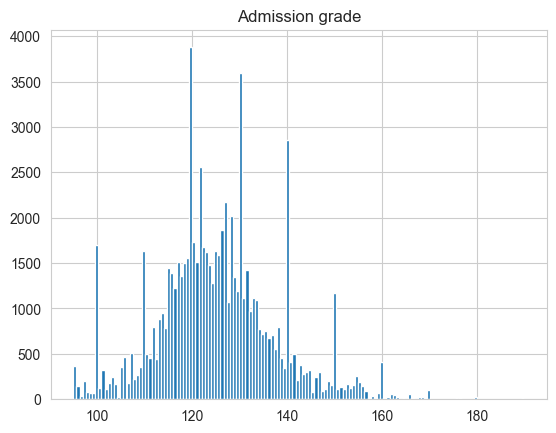

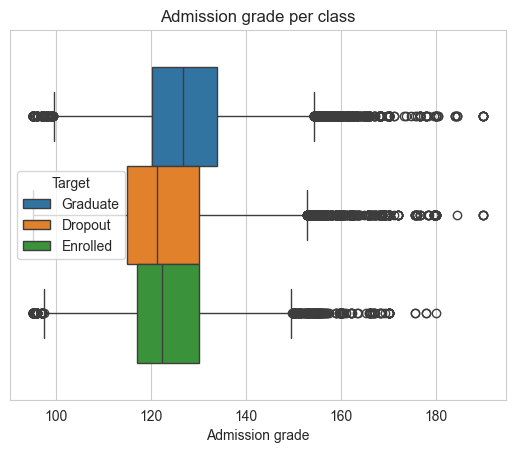

Age at enrollment


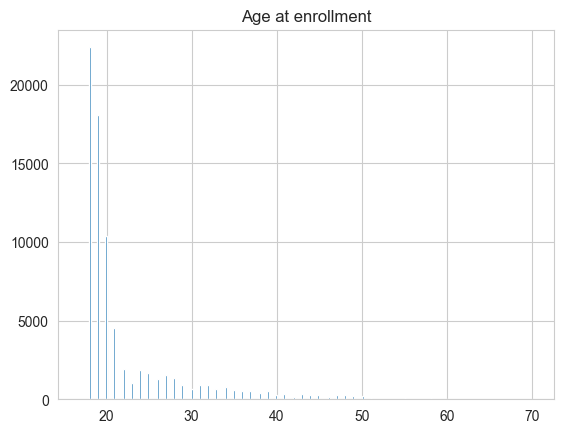

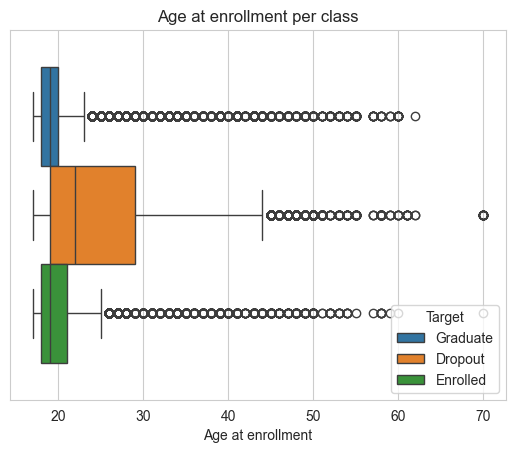

Curricular units 1st sem (grade)


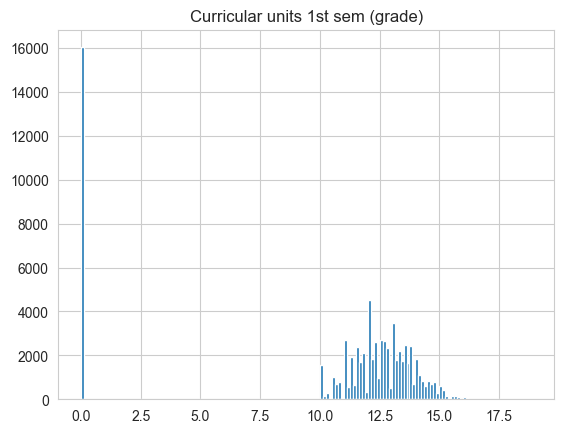

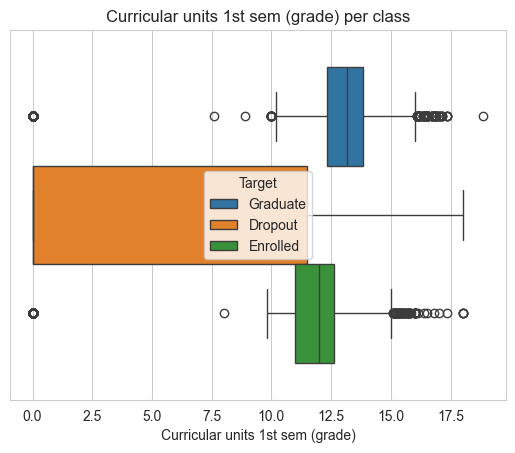

Curricular units 2nd sem (grade)


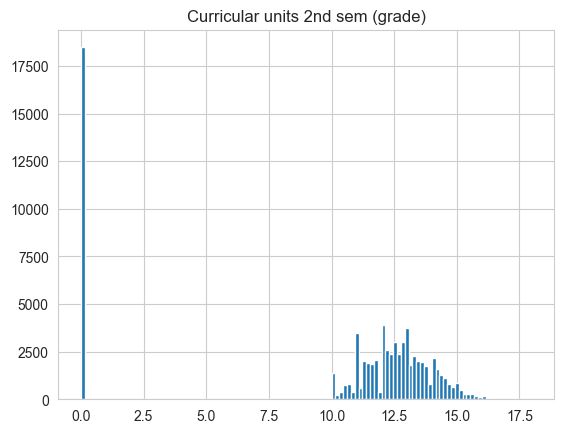

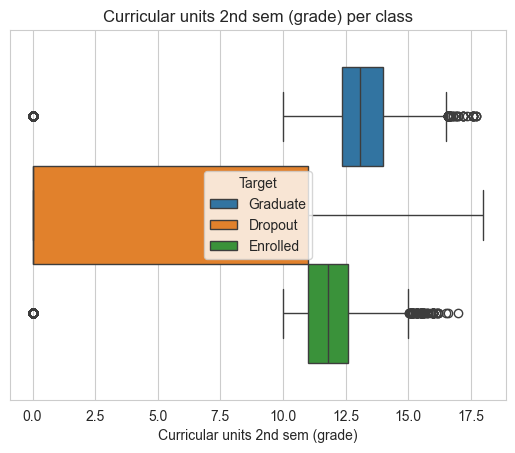

Unemployment rate


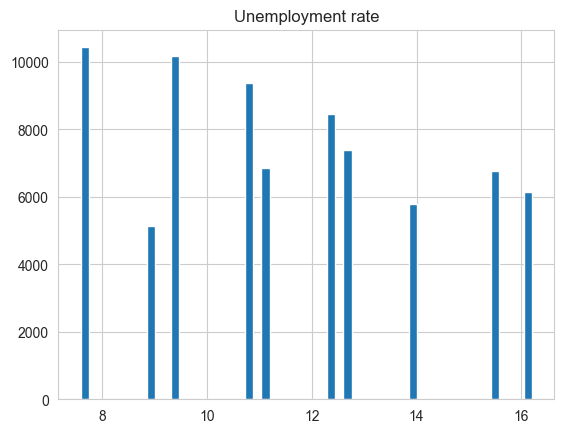

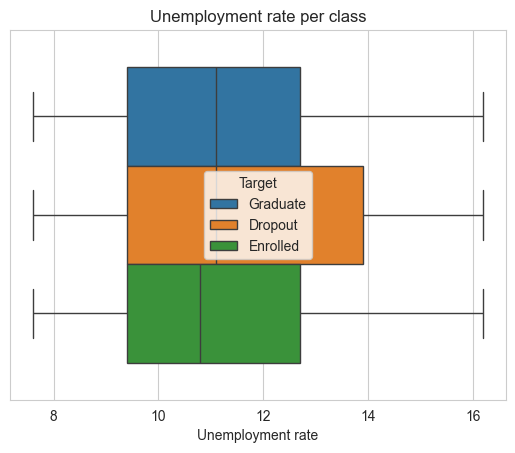

Inflation rate


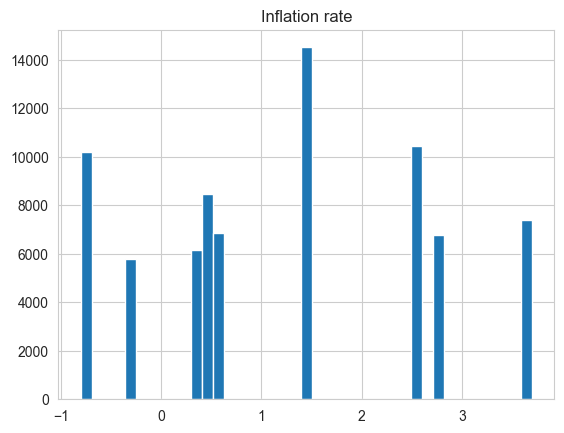

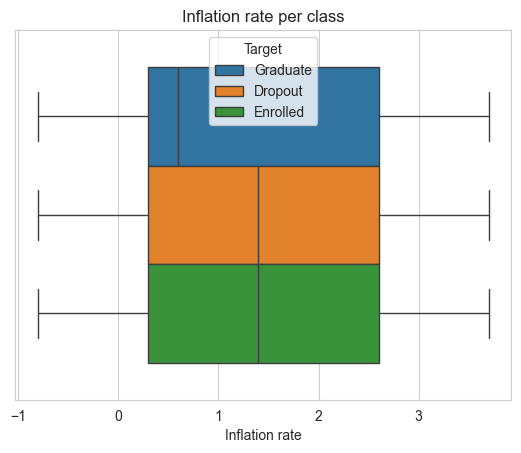

GDP


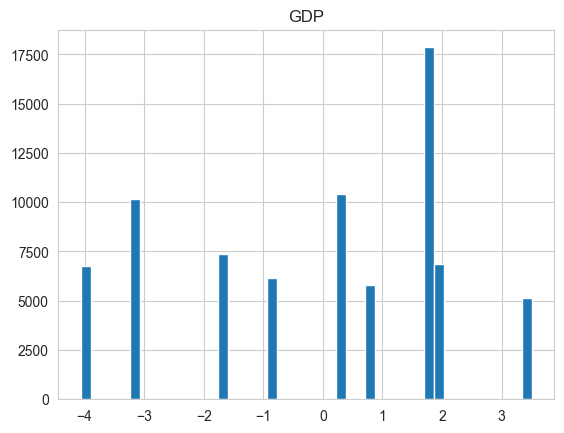

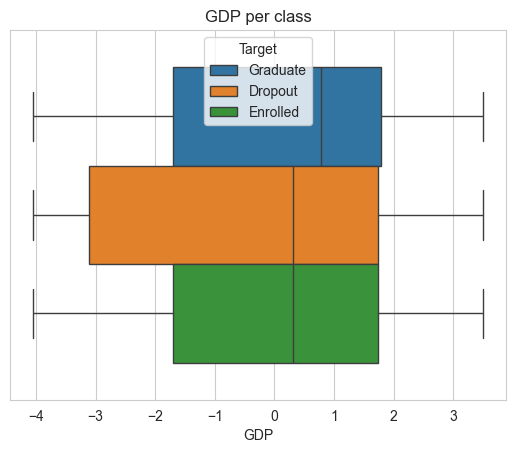

In [28]:
for column in numerical_columns:
    print(column)
    # Calculate the IQR (Interquartile Range)
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the bin width using Freedman-Diaconis rule
    bin_width = 2 * IQR * (len(train_df[column]) ** (-1/3))

    # Determine the number of bins
    num_bins = int((train_df[column].max() - train_df[column].min()) / bin_width)
    plt.hist(train_df[column], bins=num_bins)
    plt.title(column)
    plt.show()

    sns.boxplot(data=train_df, x=column, hue="Target")
    plt.title(f"{column} per class")
    plt.show()


# Look at the distribution of categorical columns

Marital status


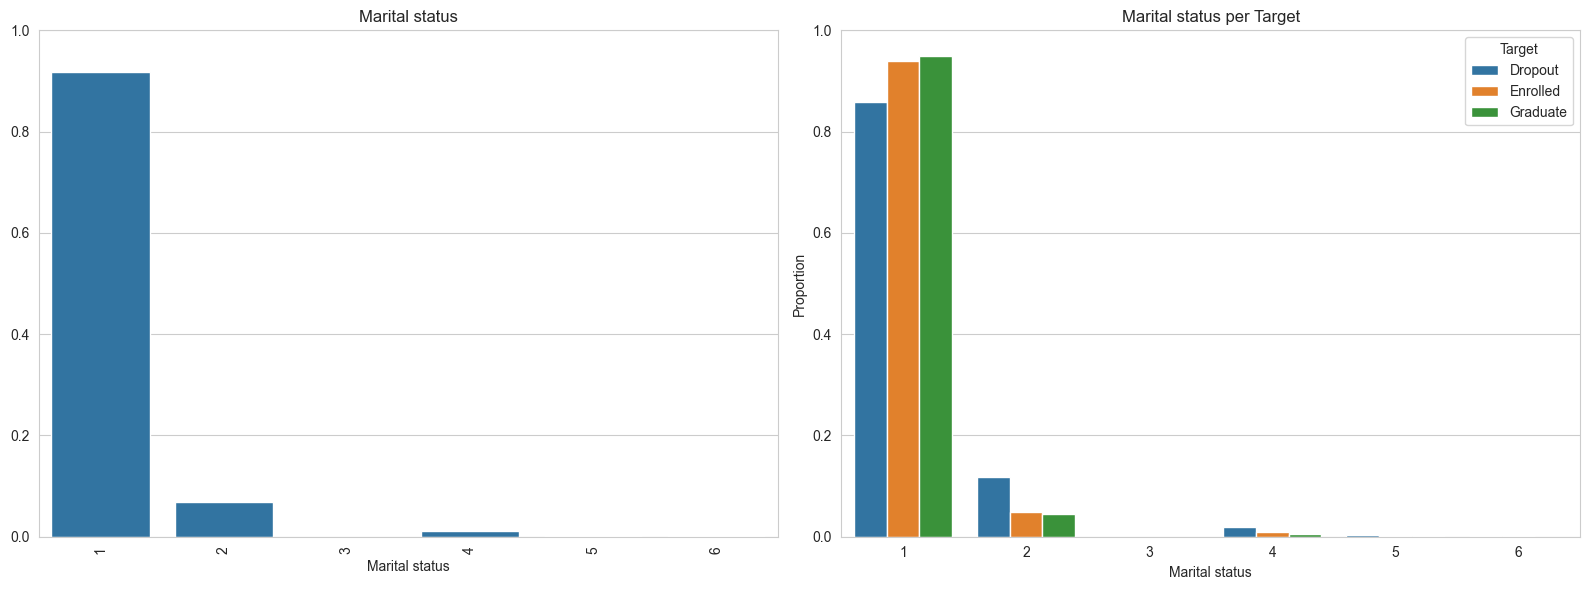

Application mode


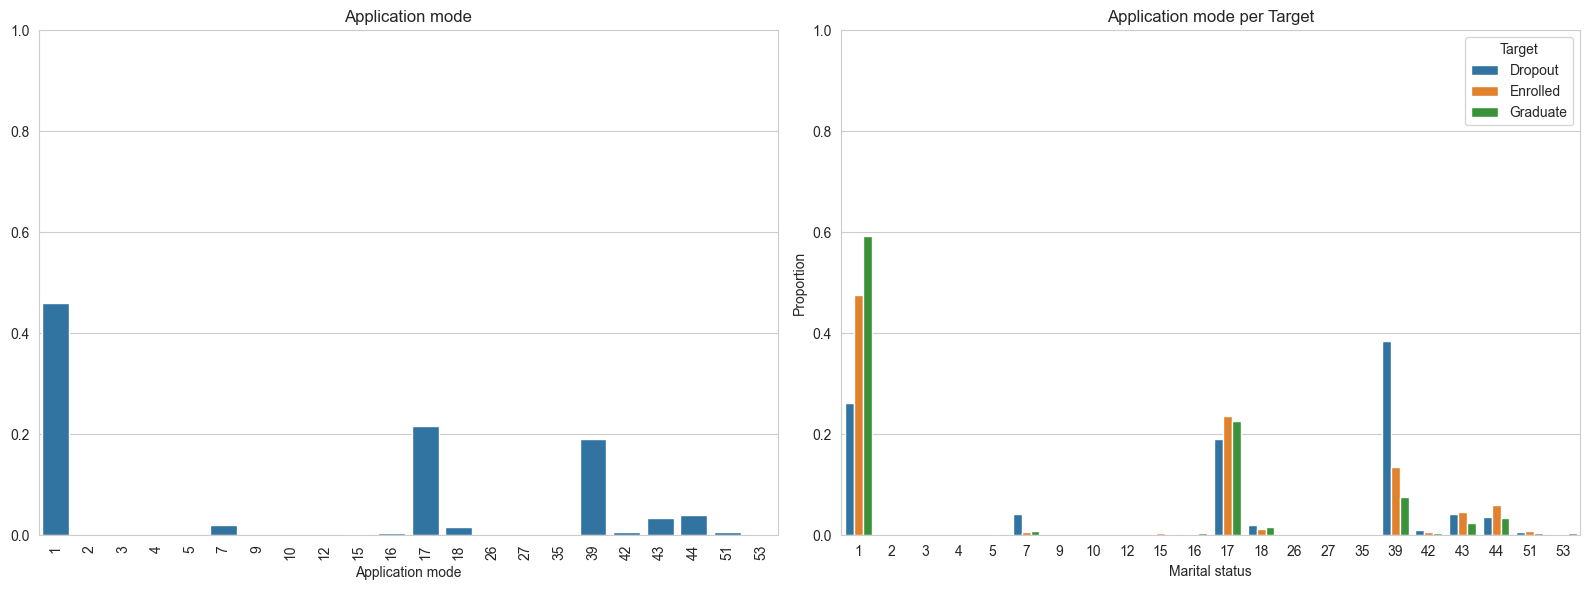

Application order


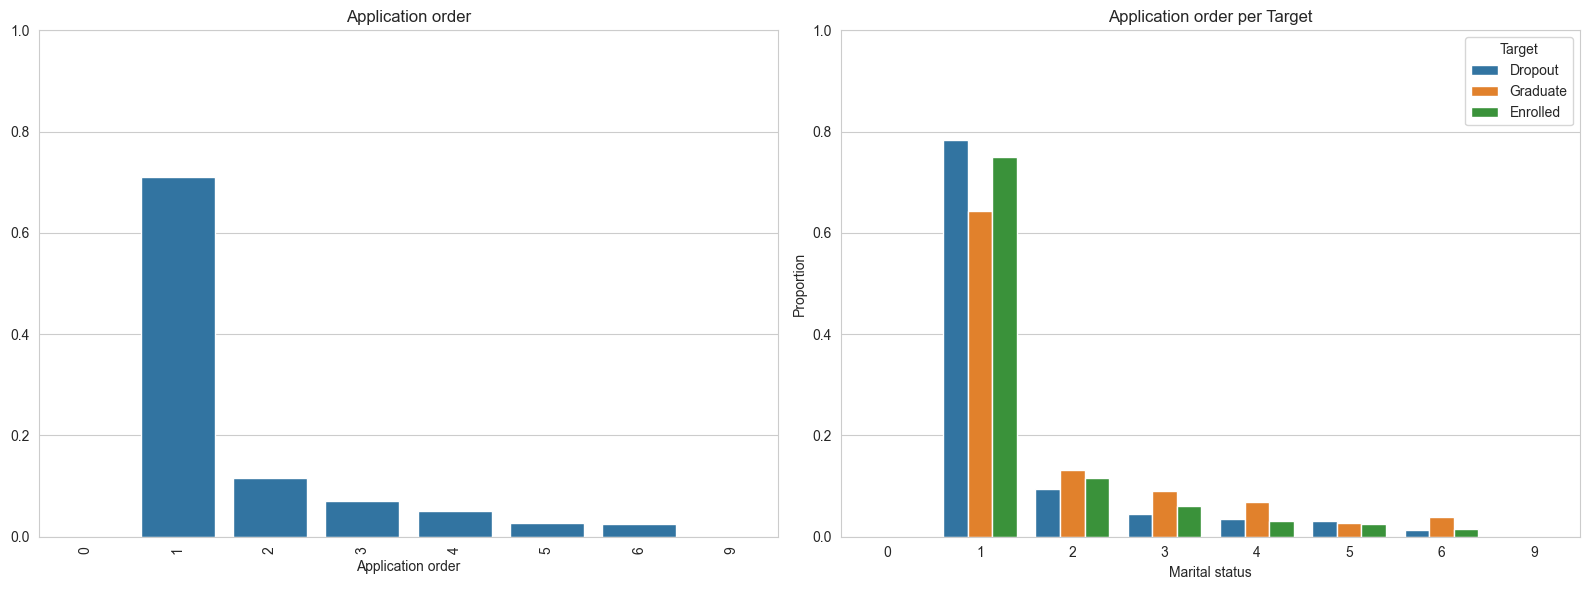

Course


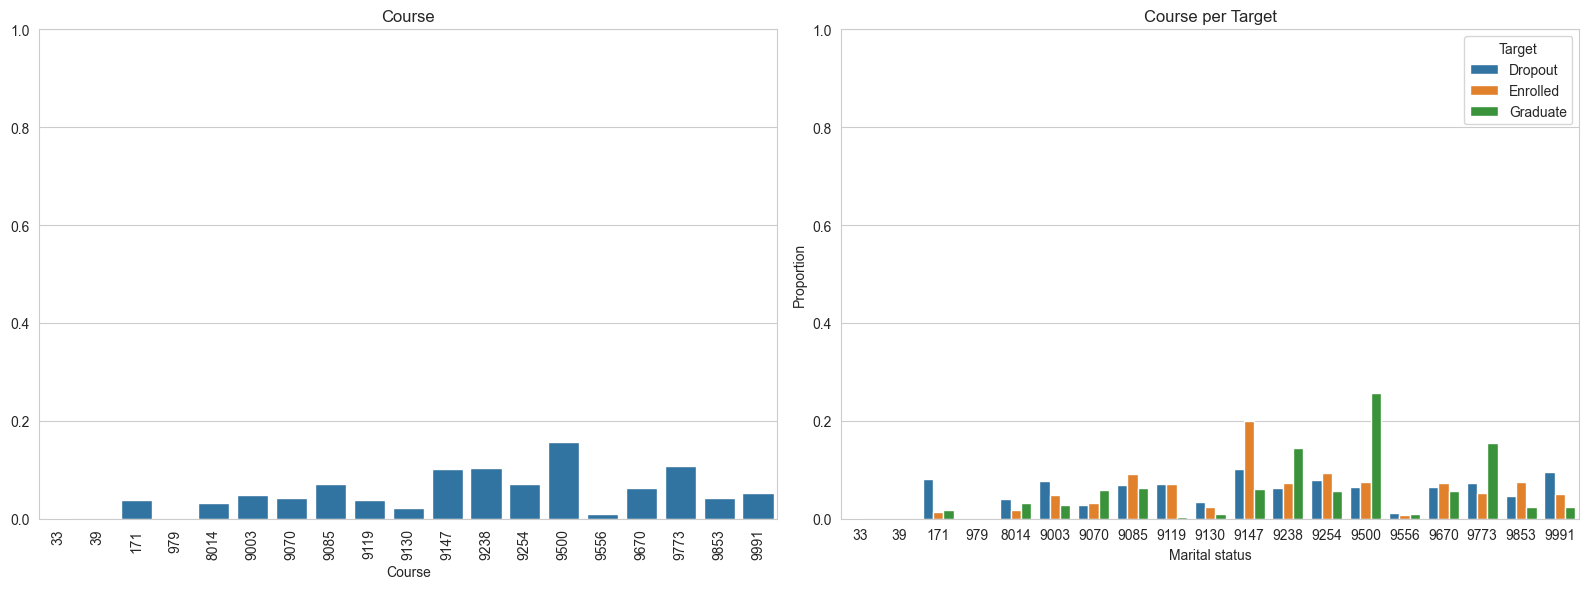

Daytime/evening attendance


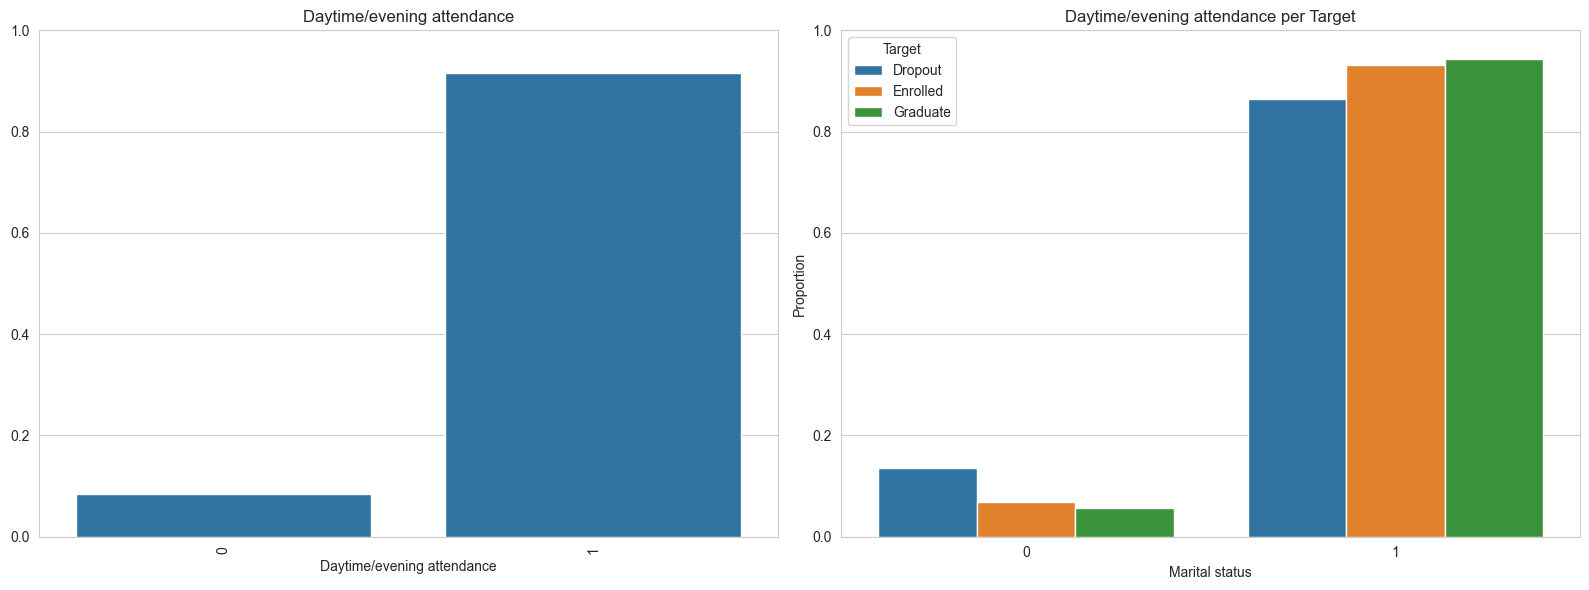

Previous qualification


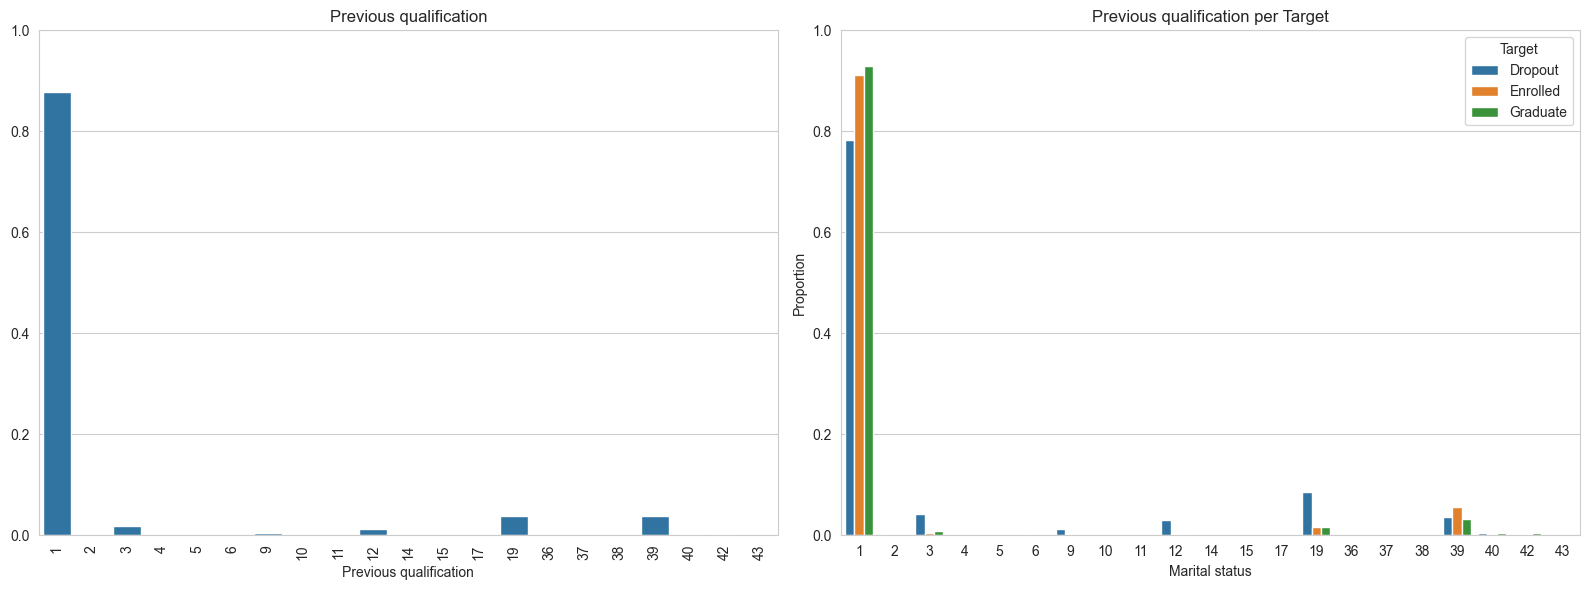

Nacionality


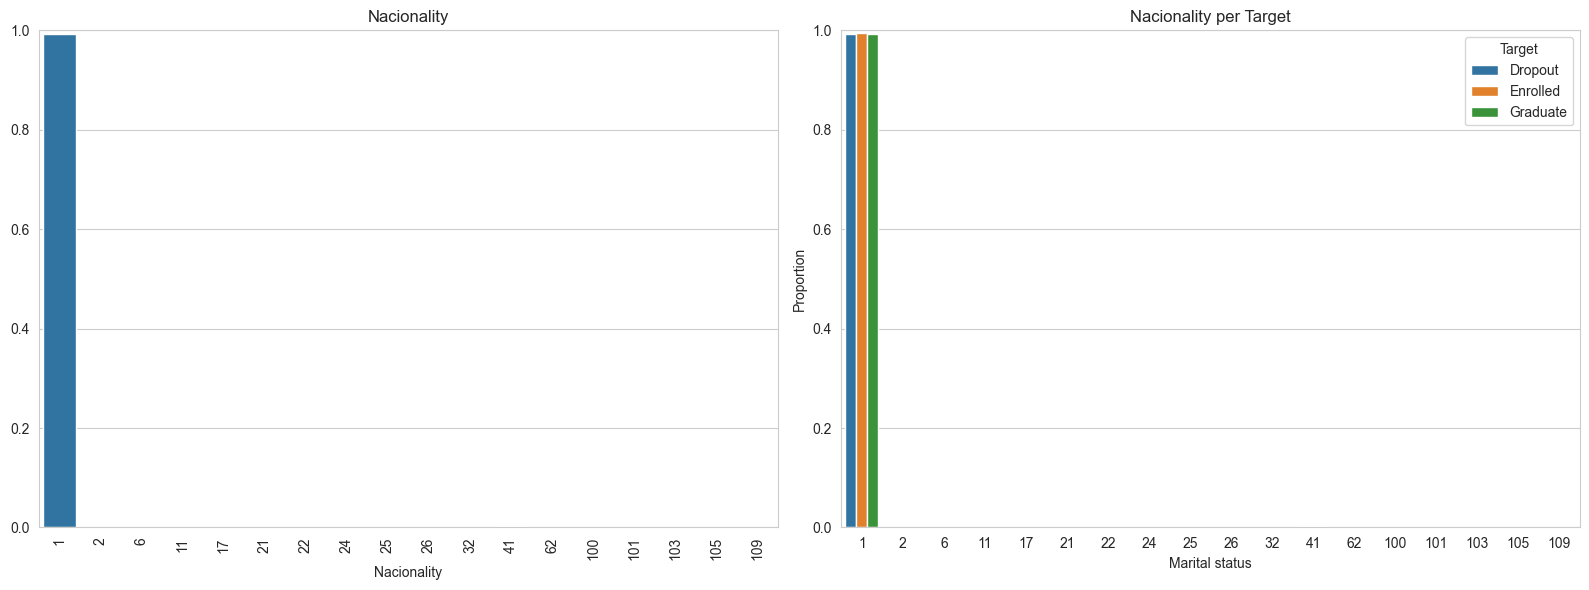

Mother's qualification


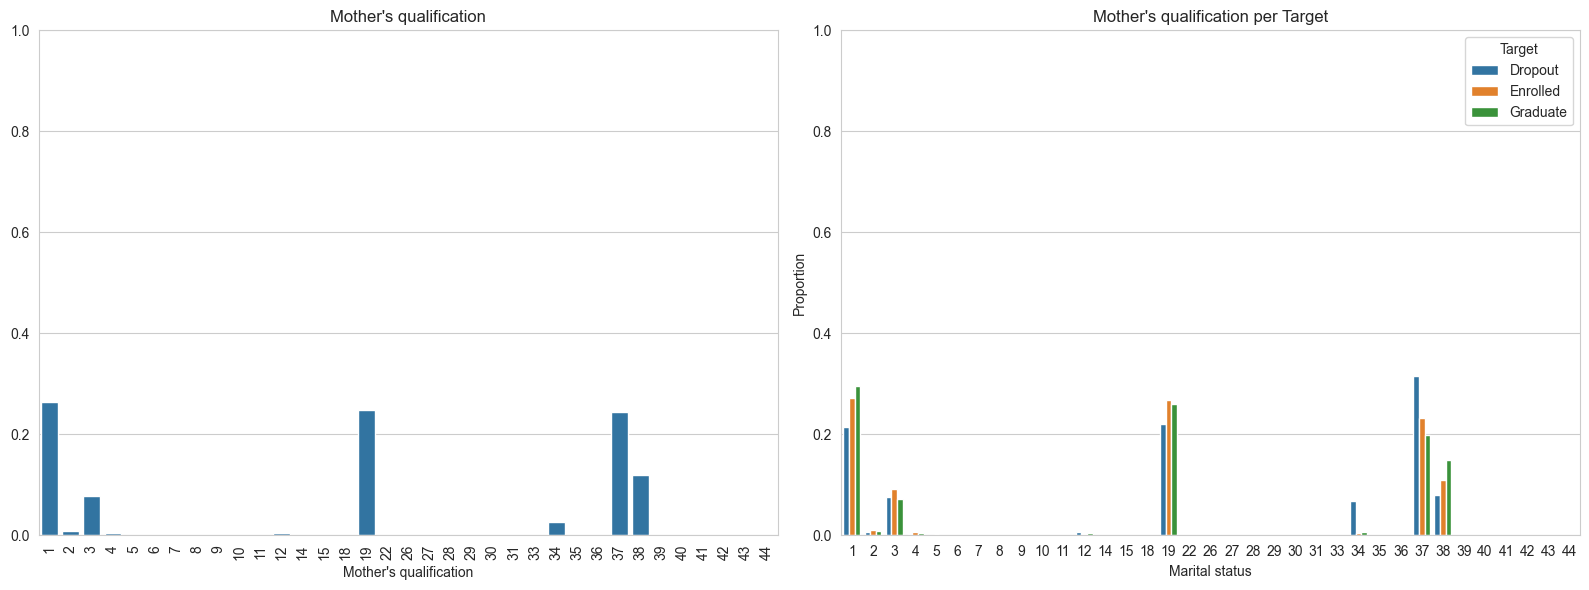

Father's qualification


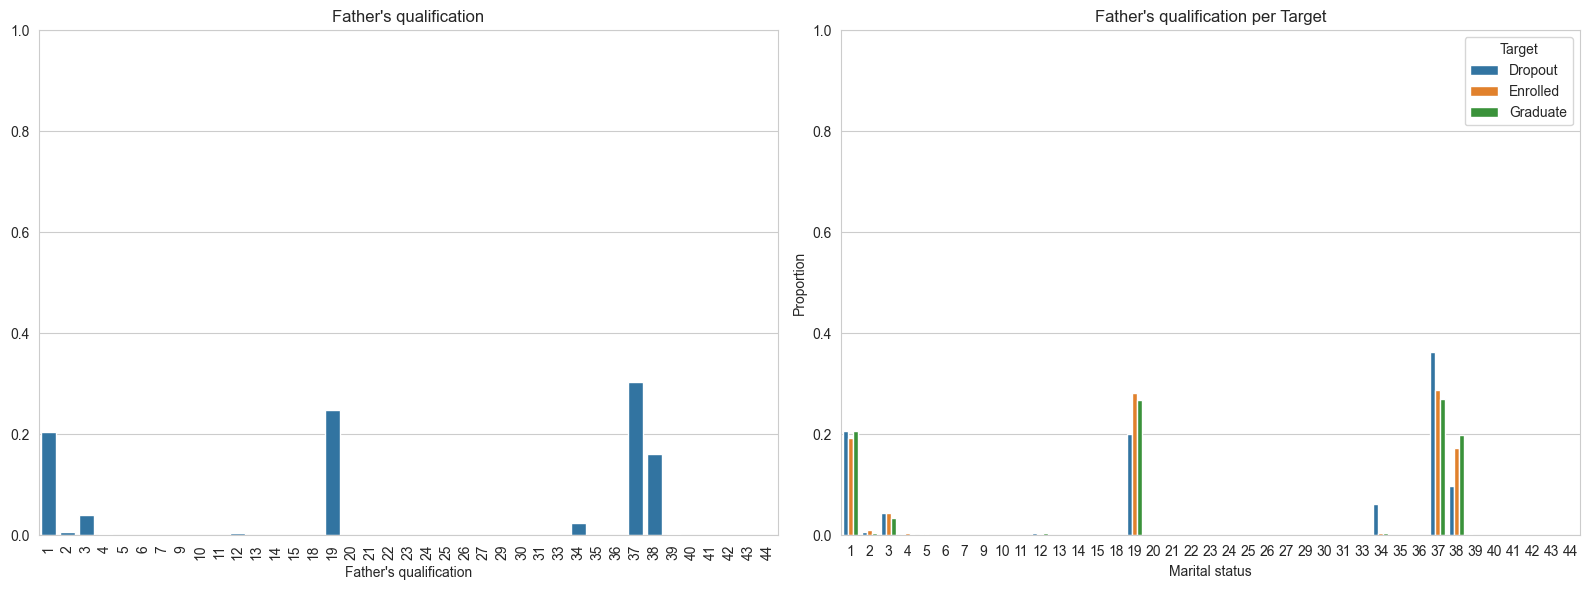

Mother's occupation


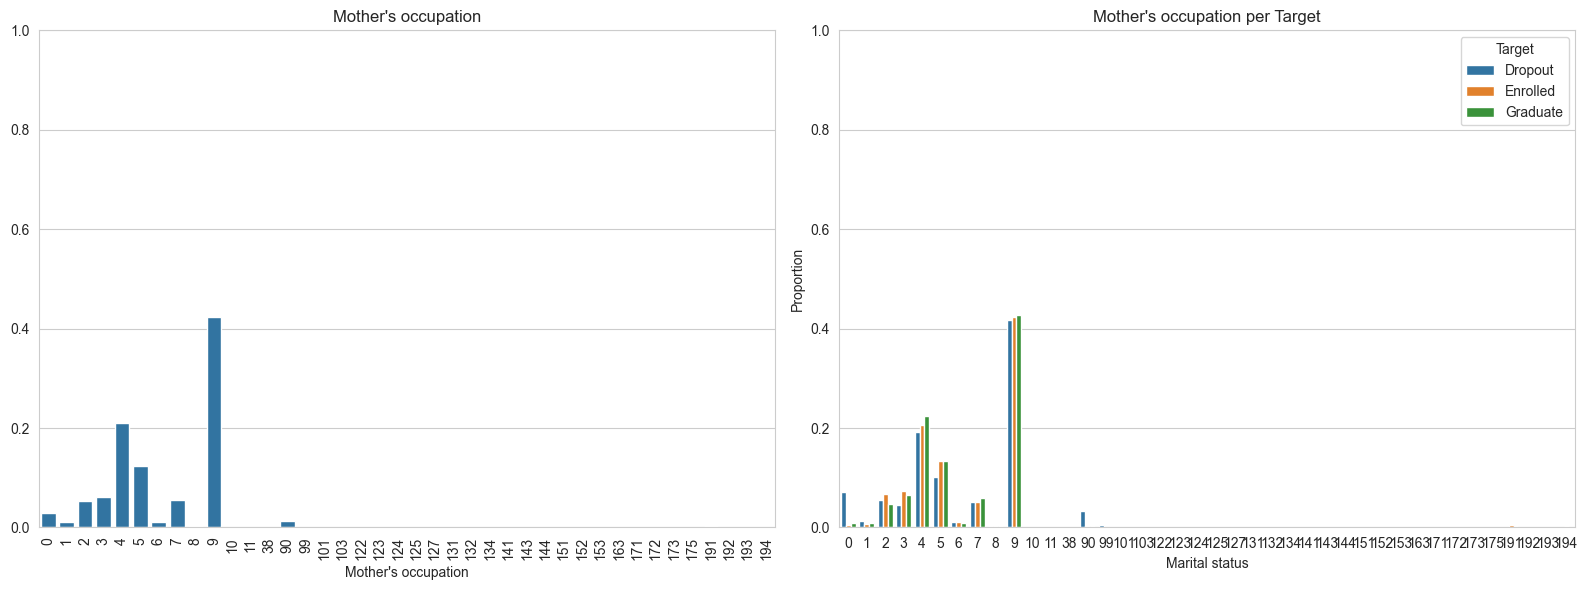

Father's occupation


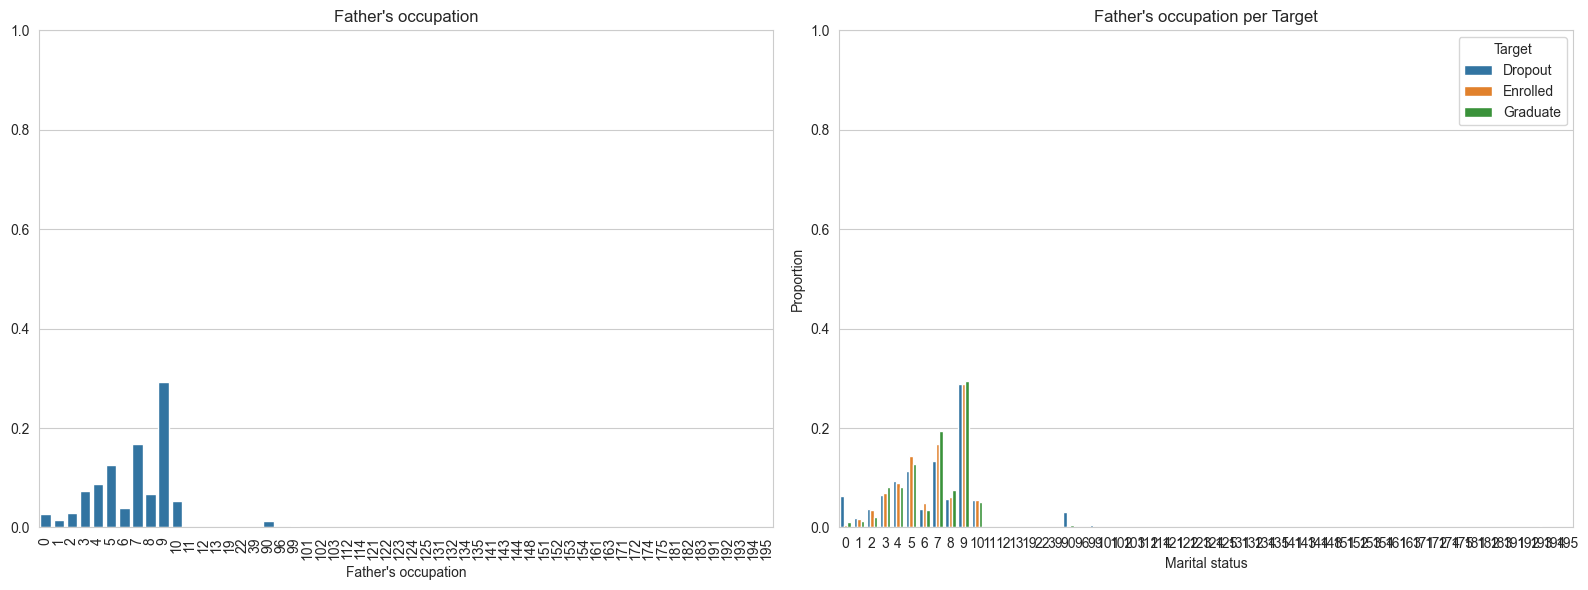

Displaced


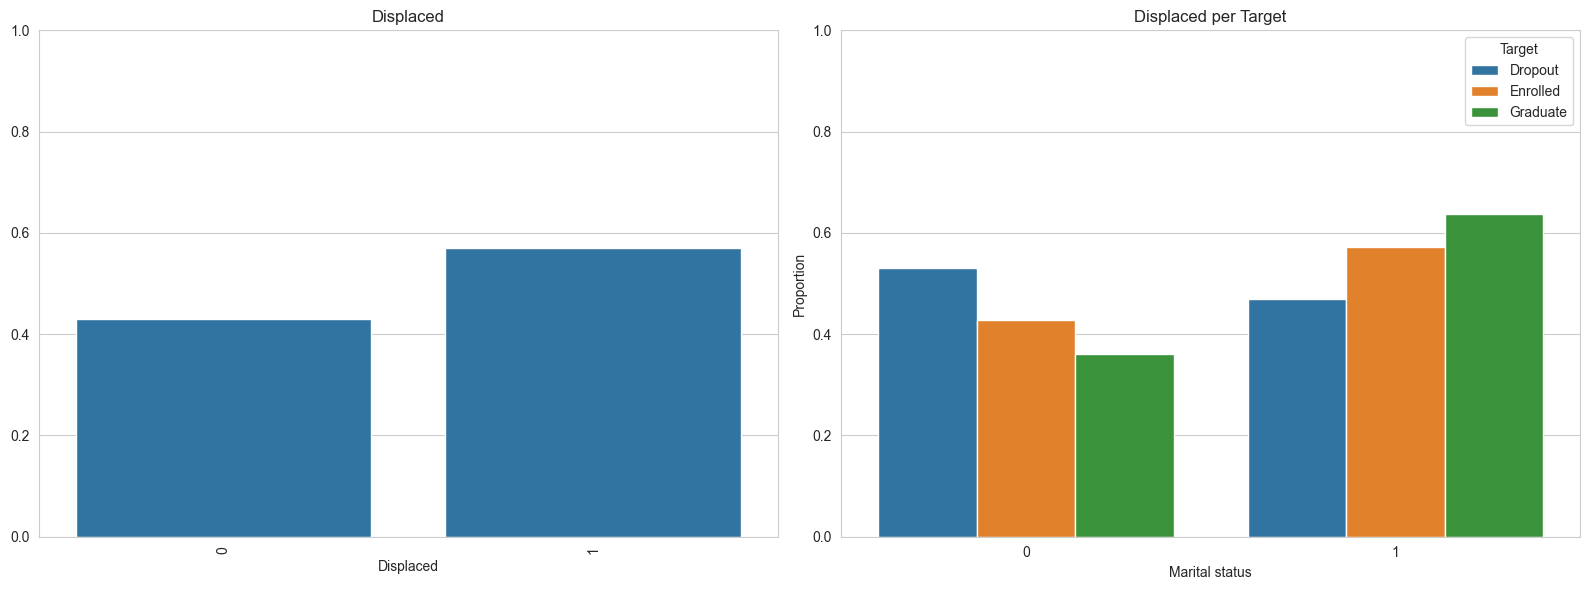

Educational special needs


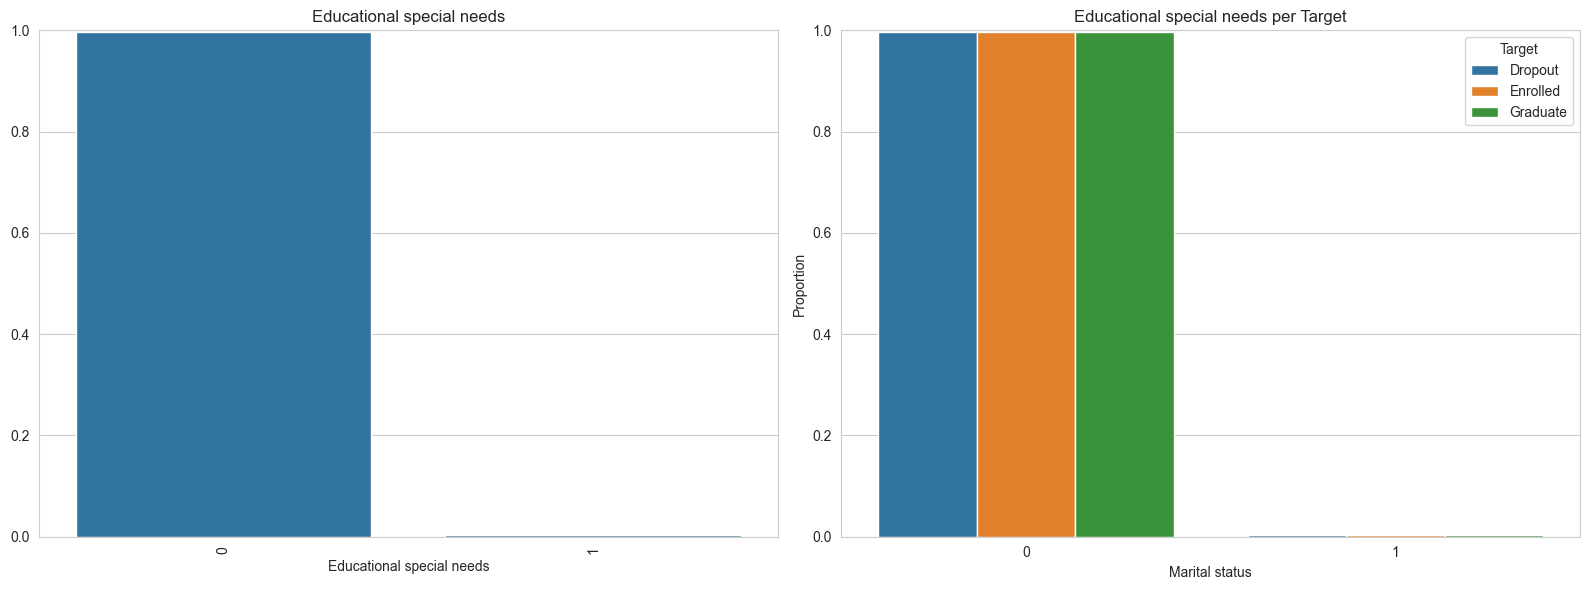

Debtor


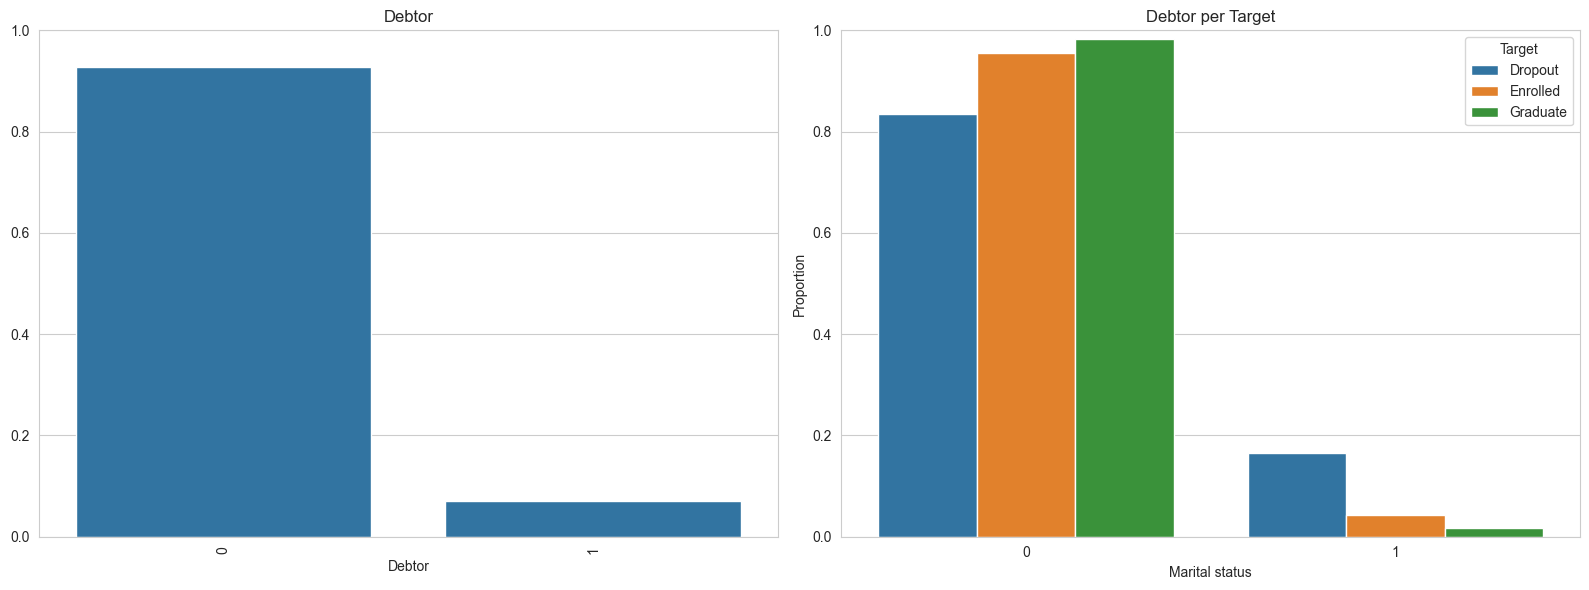

Tuition fees up to date


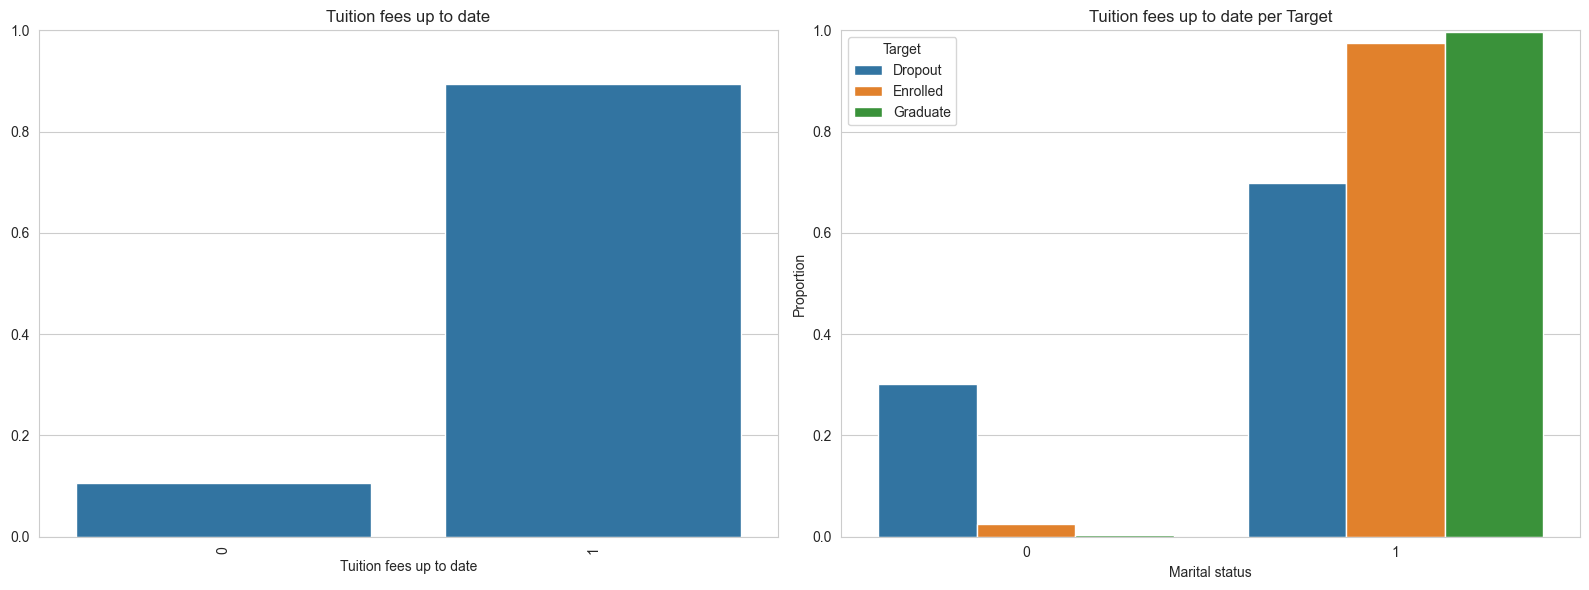

Gender


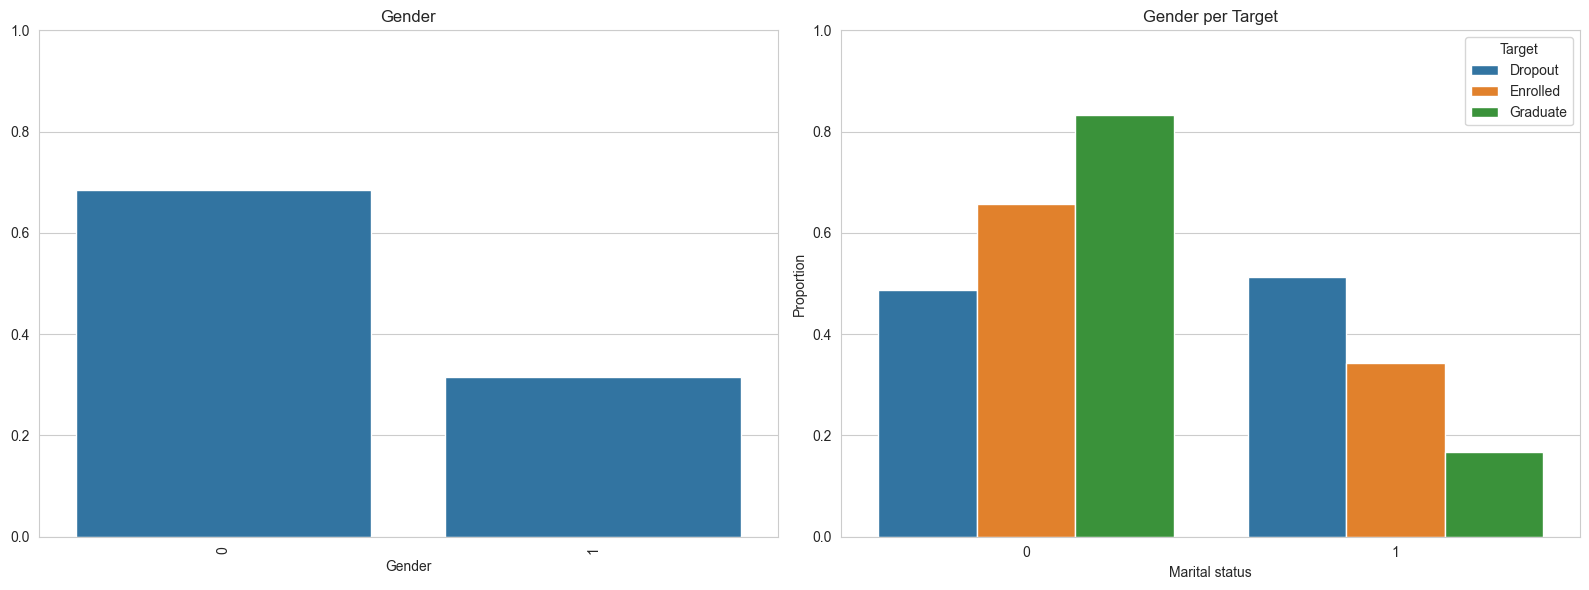

Scholarship holder


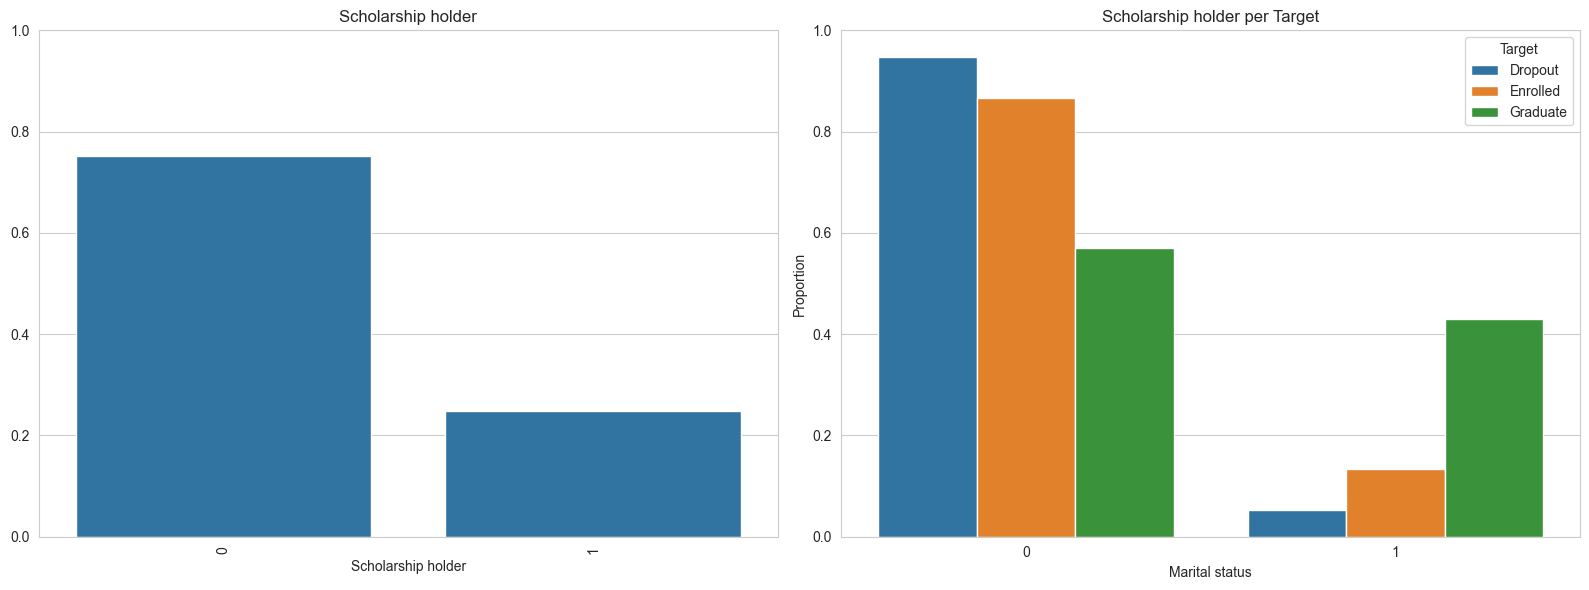

International


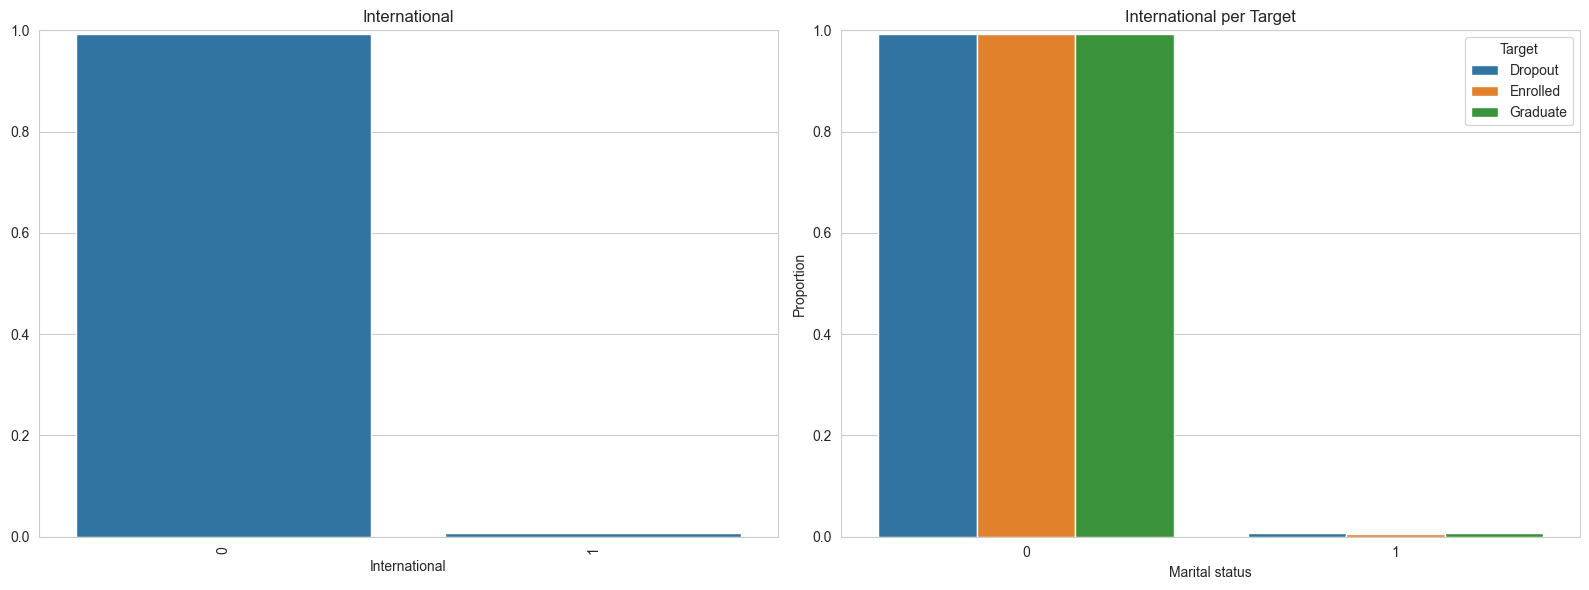

Curricular units 1st sem (credited)


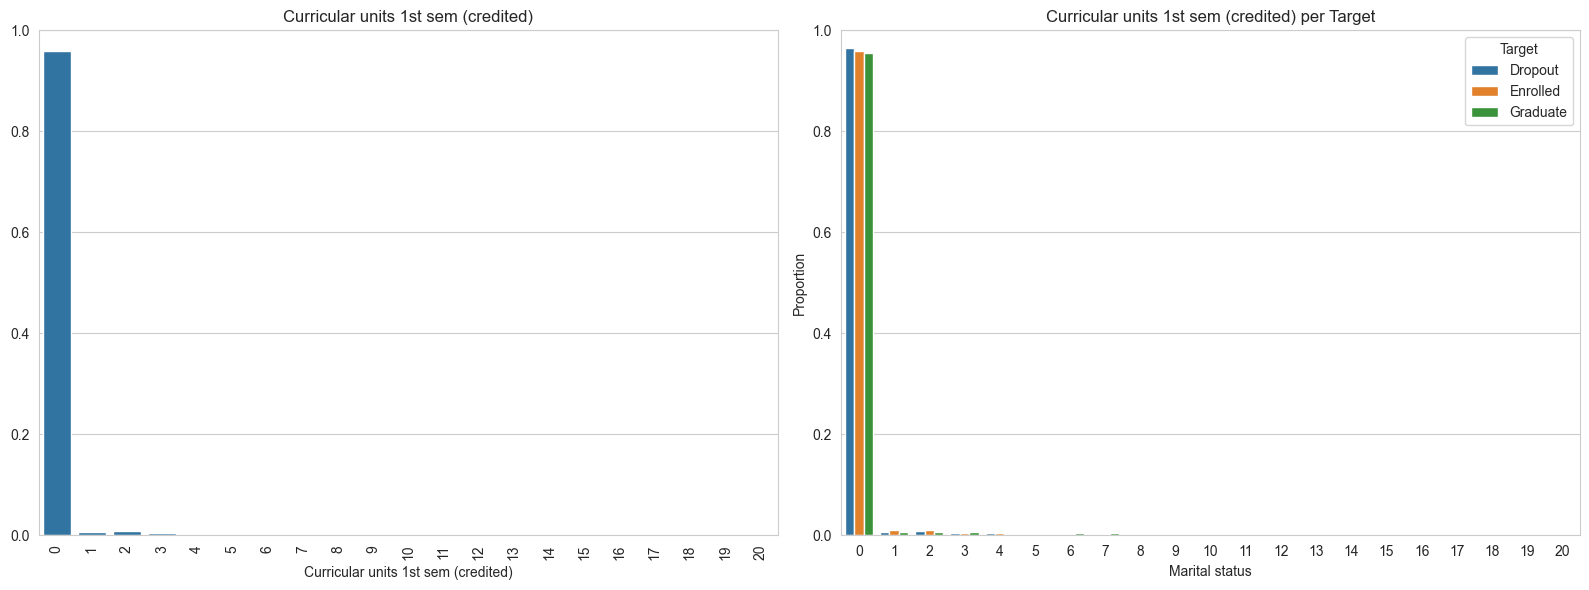

Curricular units 1st sem (enrolled)


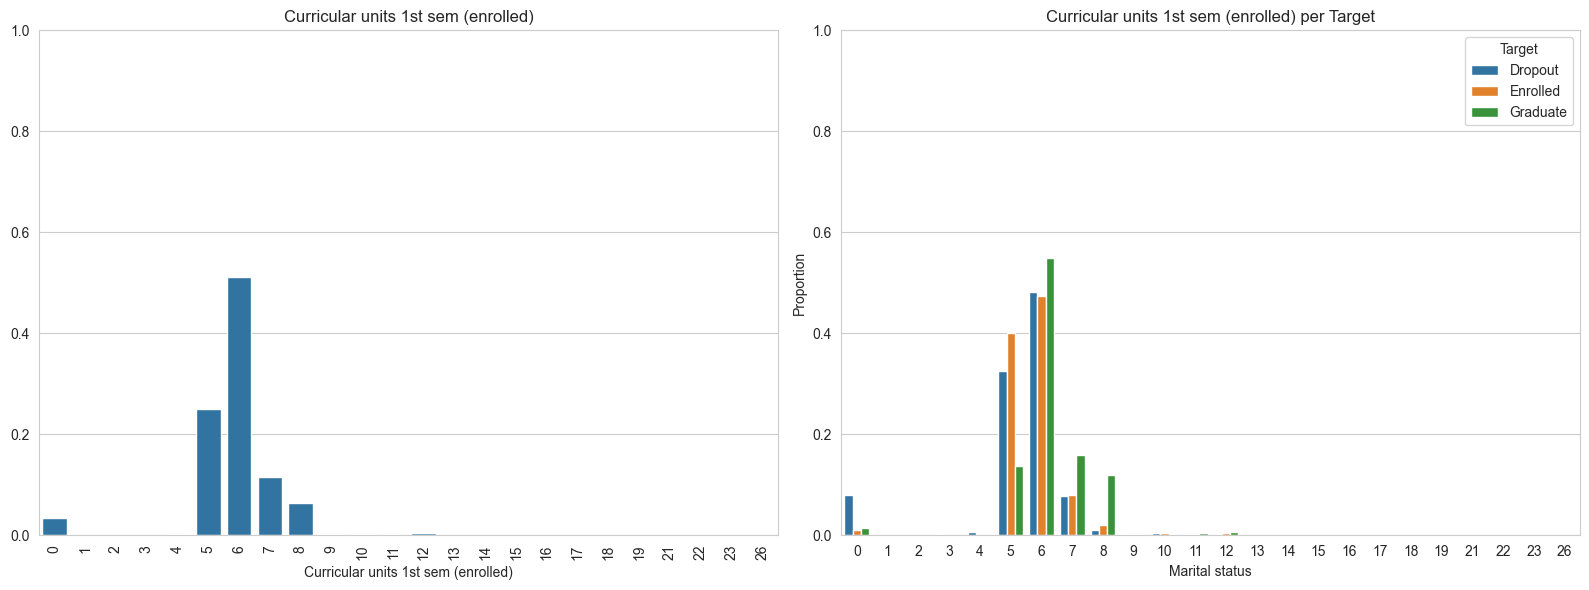

Curricular units 1st sem (evaluations)


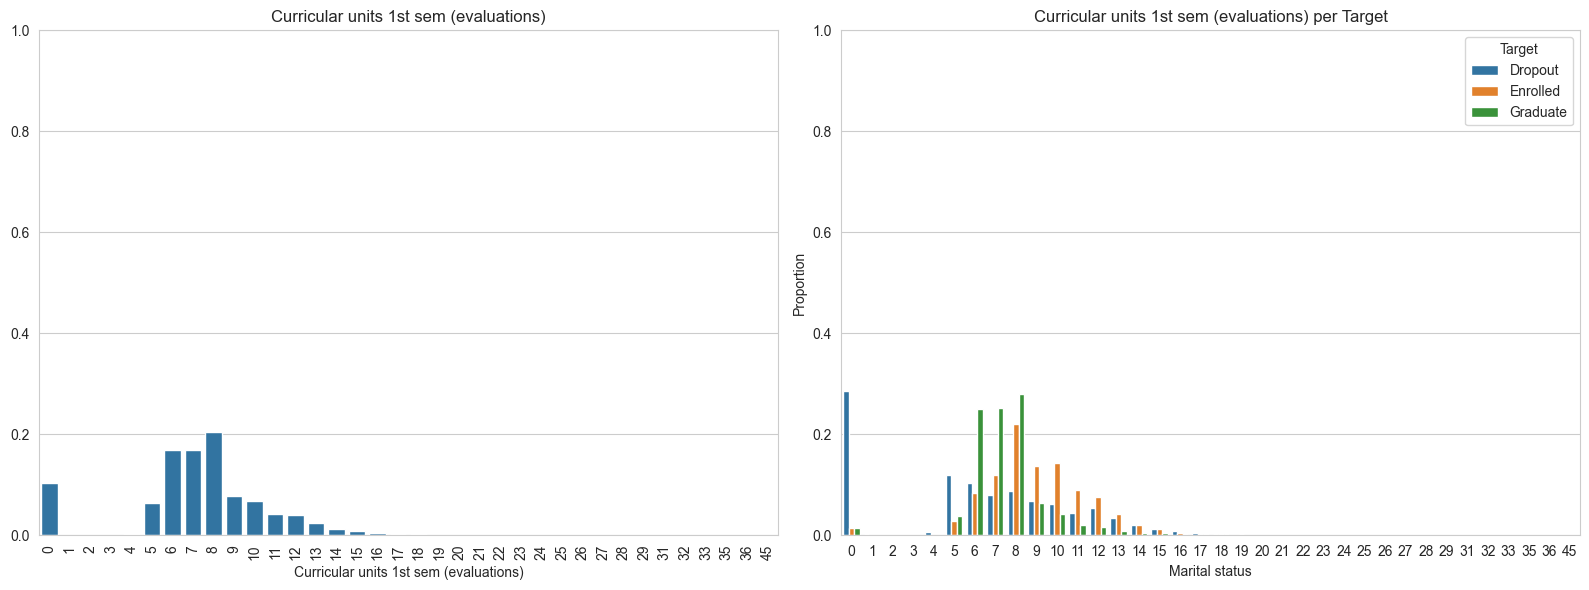

Curricular units 1st sem (approved)


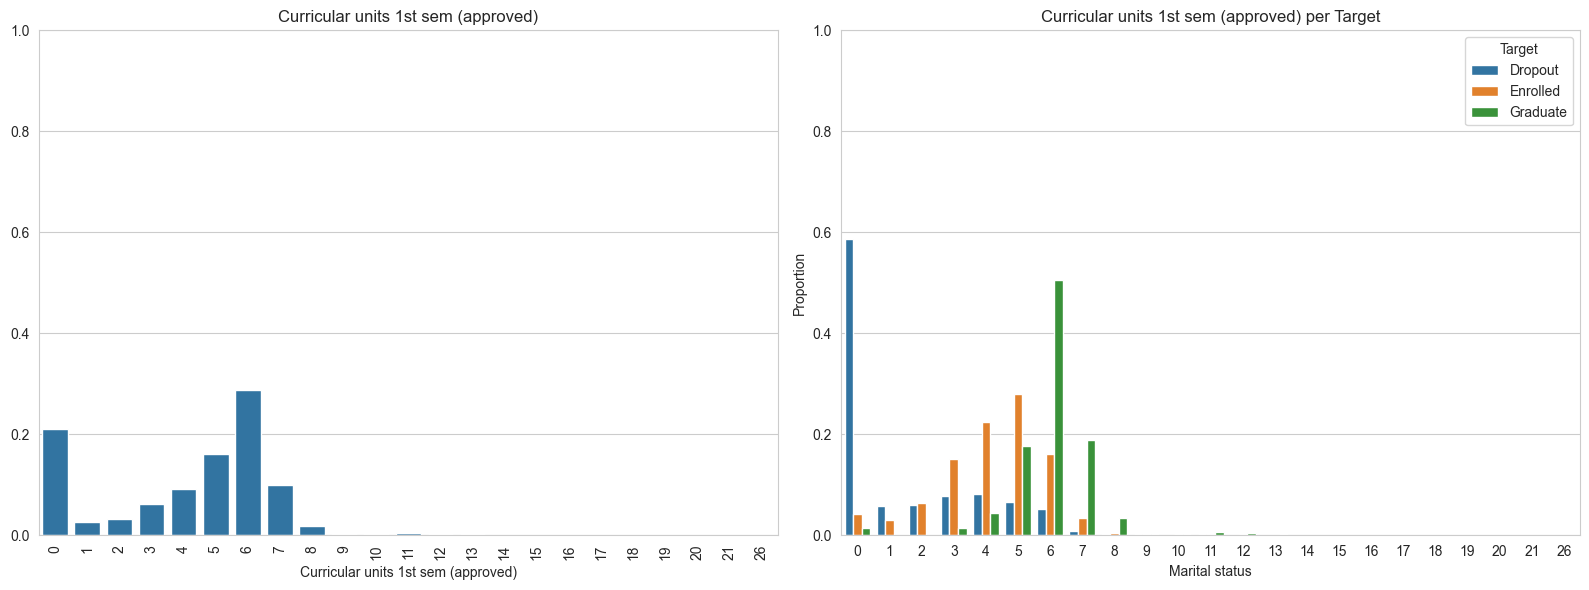

Curricular units 1st sem (without evaluations)


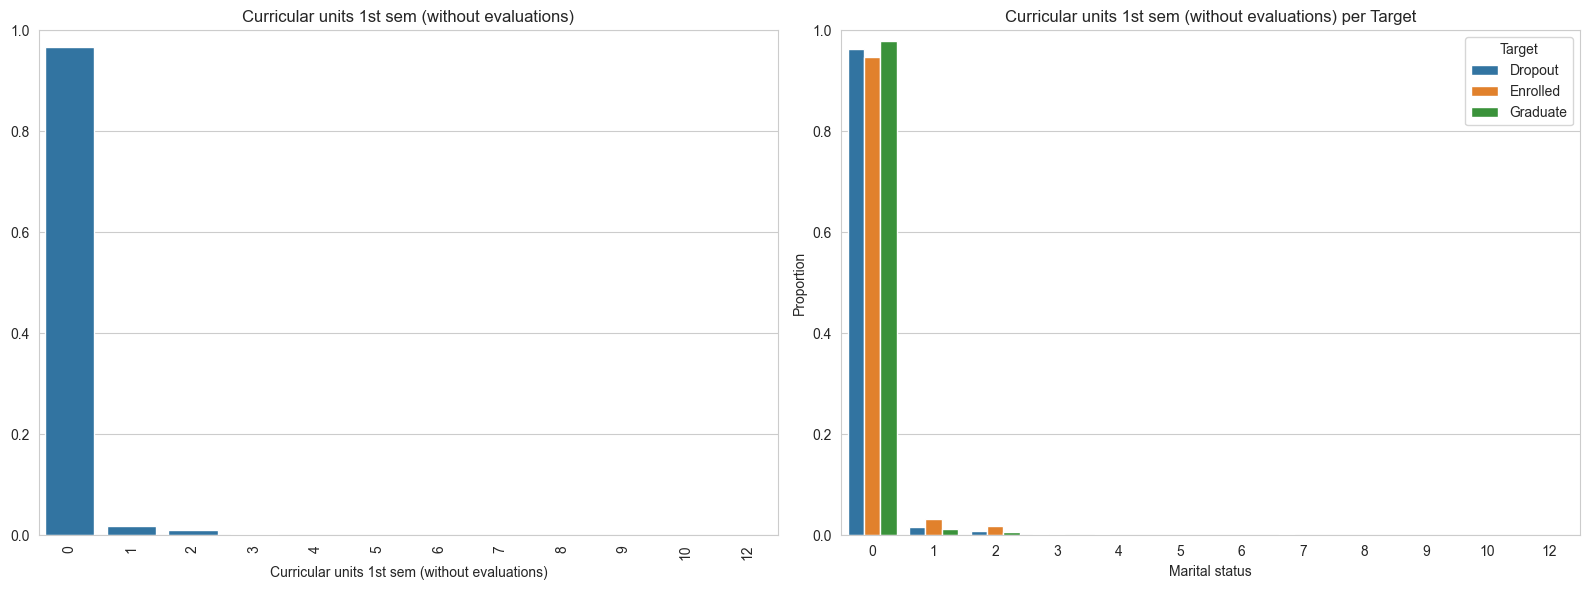

Curricular units 2nd sem (credited)


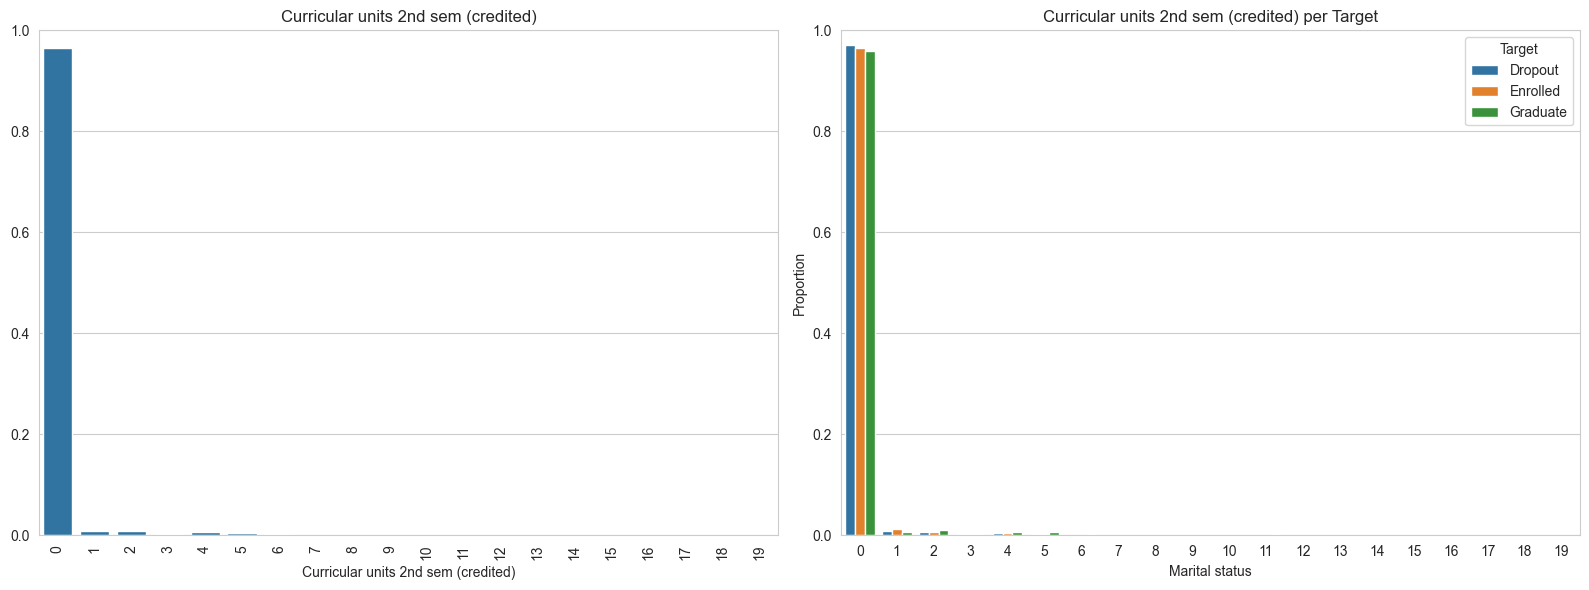

Curricular units 2nd sem (enrolled)


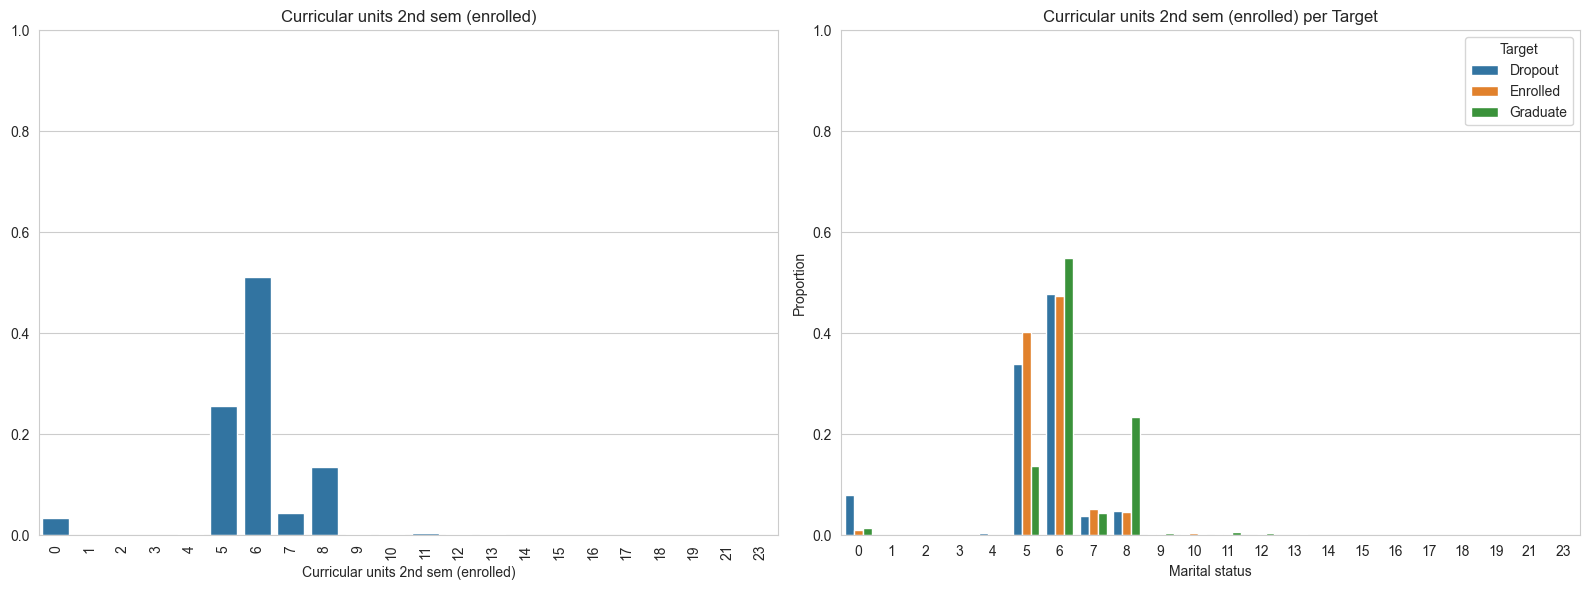

Curricular units 2nd sem (evaluations)


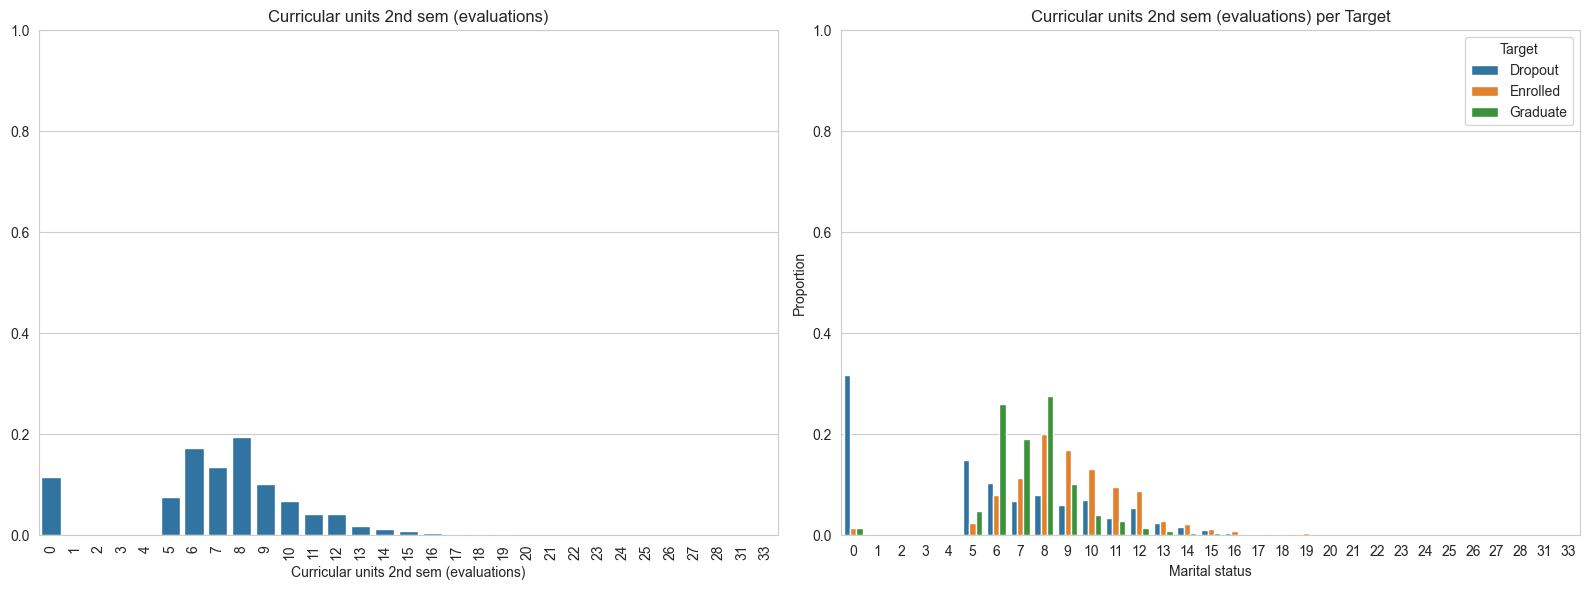

Curricular units 2nd sem (approved)


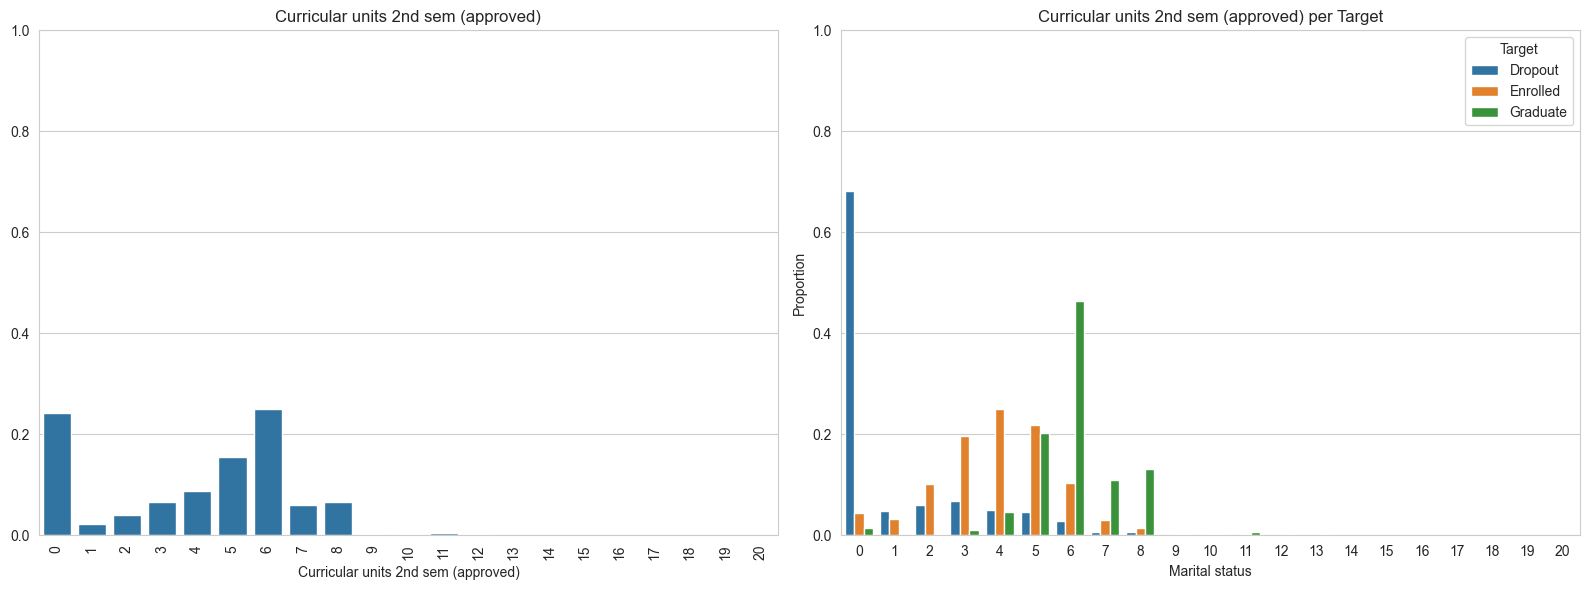

Curricular units 2nd sem (without evaluations)


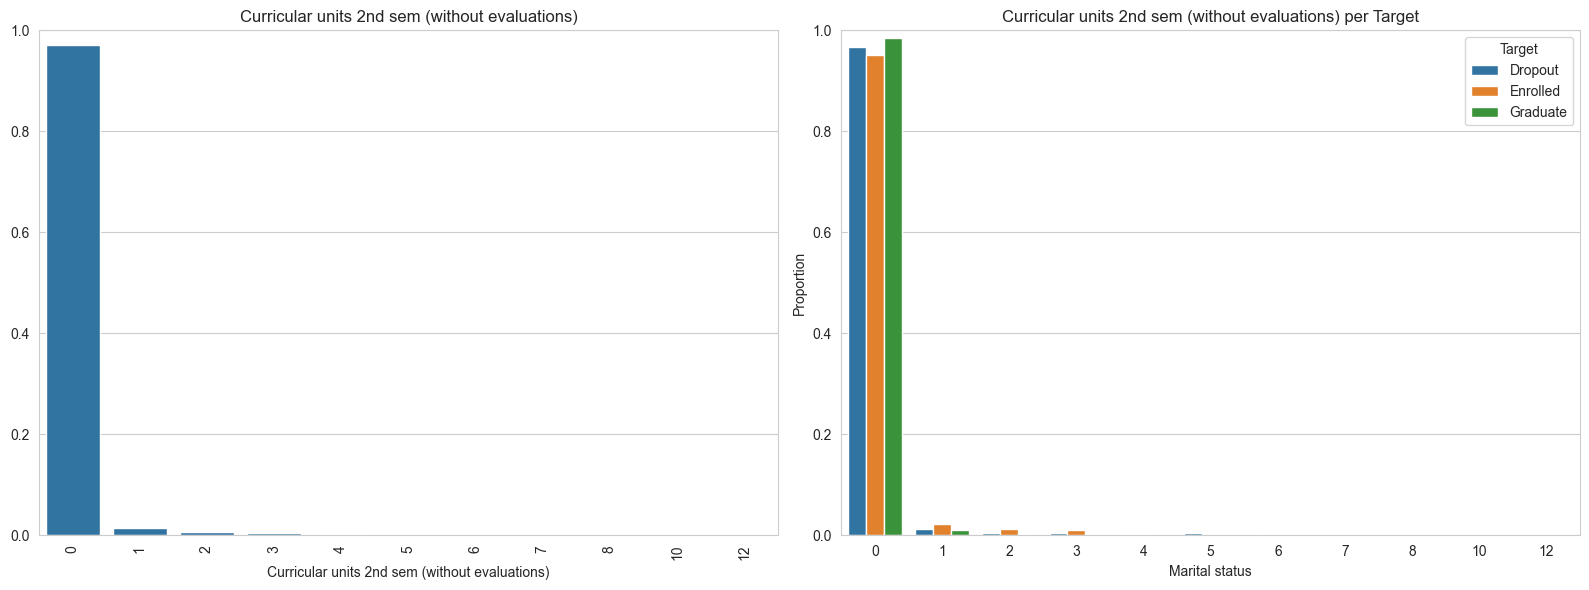

In [29]:
for column in categorical_columns:
    print(column)
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ratios = train_df[column].value_counts(normalize=True)
    sns.barplot(ax=axes[0], x=ratios.index, y=ratios.to_list())
    axes[0].set_title(column)
    axes[0].tick_params(axis="x", labelrotation=90)
    axes[0].set_ylim(0, 1)

    
    grouped_counts = train_df.groupby("Target")[column].value_counts(normalize=True)
    flattened_df = grouped_counts.reset_index()
    flattened_df.columns =  ['Target', 'Marital status', 'Proportion']
    sns.barplot(x=flattened_df["Marital status"], y=flattened_df["Proportion"], hue=flattened_df["Target"])
    axes[1].set_title(f"{column} per Target")
    axes[0].tick_params(axis="x", labelrotation=90)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Drop unneeded columns, like id

In [30]:
columns_to_drop = ["id"]
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# Look at class balance in the training dataset

In [31]:
normalized_proportions = train_df["Target"].value_counts(normalize=True)
normalized_proportions

Target
Graduate    0.474163
Dropout     0.330589
Enrolled    0.195248
Name: proportion, dtype: float64

In [32]:
# Get classes to undersample
classes_to_undersample = normalized_proportions.index.to_list()[:-1]
# Get class with smallest proportion
class_with_smallest_propotion = normalized_proportions.index.to_list().pop()

In [33]:
# Get row number of class with smallest proportion
rows_of_class_with_smallest_proportion = train_df[train_df["Target"] == class_with_smallest_propotion].shape[0]
rows_of_class_with_smallest_proportion

14940

In [34]:
# Undersample larger classes and combine them to an array
undersampled_dfs = []
for x in classes_to_undersample:
    majority_class_df = train_df[train_df["Target"] == x]
    undersampled_df = majority_class_df.sample(rows_of_class_with_smallest_proportion)
    undersampled_dfs.append(undersampled_df)


In [35]:
# Combine the undersampled classes together with the smallest class
undersampled_dfs.append(train_df[train_df["Target"] == class_with_smallest_propotion])
train_df = pd.concat(undersampled_dfs)

In [36]:
normalized_proportions = train_df["Target"].value_counts(normalize=True)
normalized_proportions

Target
Graduate    0.333333
Dropout     0.333333
Enrolled    0.333333
Name: proportion, dtype: float64

The dataset is balanced

# Skew of numerical columns

In [37]:
train_df[numerical_columns].skew()

Previous qualification (grade)      0.232484
Admission grade                     0.422738
Age at enrollment                   2.320752
Curricular units 1st sem (grade)   -1.230429
Curricular units 2nd sem (grade)   -1.028652
Unemployment rate                   0.252801
Inflation rate                      0.206437
GDP                                -0.357717
dtype: float64